<a href="https://colab.research.google.com/github/alvinrach/21-Car-Insurance-Sales-Prediction/blob/main/(Manually_Tuned_Version)_Alvin_Rachmat_DPhi_Datathon_Notebook_Car_Insurance_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will show you how to predict sales of the car insurance based of some data like marital status, job type, etc. This notebook is related to this competition, where i managed to be the big three in a final assignment of the bootcamp (my name there is appeared as alvinrach).

https://dphi.tech/challenges/getting-started-with-data-science-bootcamp-final-assignment/74/leaderboard/datathon/

The test data however have no target, as the predicted target will be graded by their submission system.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
pd.options.display.max_columns=None
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Load the Dataset

In [2]:
d=pd.read_csv('https://raw.githubusercontent.com/alvinrach/21-Car-Insurance-Sales-Prediction/main/Train_data.csv')
f=pd.read_csv('https://raw.githubusercontent.com/alvinrach/21-Car-Insurance-Sales-Prediction/main/Test_data.csv');

# Exploratory Data Analysis (EDA)

## Null Checking

In [3]:
for k in d,f:
    print(k.isna().mean()*100)
    print(k.days_passed.value_counts())

age                     0.000000
job_type                0.354610
marital_status          0.000000
education_level         3.642811
default_or_not          0.000000
balance_amt             0.000000
household_insurance     0.000000
car_loan                0.000000
communication          17.504836
last_contact_day        0.000000
last_contact_month      0.000000
no_of_contacts          0.000000
days_passed             0.000000
prev_attempts           0.000000
Outcome                75.789813
call_start              0.000000
call_end                0.000000
car_insurance           0.000000
dtype: float64
-1      2219
 92       30
 182      22
 91       19
 183      18
        ... 
 7         1
 854       1
 842       1
 690       1
 0         1
Name: days_passed, Length: 321, dtype: int64
age                     0.000000
job_type                0.534759
marital_status          0.000000
education_level         3.636364
default_or_not          0.000000
balance_amt             0.000000
house

Some models can handle missing values while others dont

We will fill the outcome with mode, and keep the job_type, communication, and education unfilled

The idea will cause the nan to be filled with zero when we do get dummies

## Target Balance Checking

In [4]:
d.car_insurance.value_counts(True)*100

1    56.737589
0    43.262411
Name: car_insurance, dtype: float64

Quite balanced, so we dont need to balance it/resampling

Although, it's good to check the performa of unbalanced prediction and the balanced one

## Dupicated Rows Checking

Check info and check if the duplicates are truly dupicate

In [5]:
for k in d,f:
    k.info()
    display(k, k[k.duplicated(keep=False)].sort_values('age'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3102 non-null   float64
 1   job_type             3091 non-null   object 
 2   marital_status       3102 non-null   object 
 3   education_level      2989 non-null   object 
 4   default_or_not       3102 non-null   int64  
 5   balance_amt          3102 non-null   float64
 6   household_insurance  3102 non-null   int64  
 7   car_loan             3102 non-null   int64  
 8   communication        2559 non-null   object 
 9   last_contact_day     3102 non-null   int64  
 10  last_contact_month   3102 non-null   object 
 11  no_of_contacts       3102 non-null   int64  
 12  days_passed          3102 non-null   int64  
 13  prev_attempts        3102 non-null   int64  
 14  Outcome              751 non-null    object 
 15  call_start           3102 non-null   o

,age,job_type,marital_status,education_level,default_or_not,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end,car_insurance
0,47.000000,blue-collar,married,primary,0,1112.000000,1,0,cellular,13,may,1,-1,0,NaN,10:22:20,10:24:29,0
1,46.031442,management,married,tertiary,0,1.312372,0,1,cellular,15,may,3,219,1,other,09:06:30,13:59:48,1
2,36.000000,services,single,NaN,0,281.000000,1,0,NaN,16,may,1,-1,0,NaN,13:18:41,13:27:16,1
3,32.000000,technician,single,secondary,0,540.000000,0,1,cellular,29,jan,1,-1,0,NaN,10:09:18,10:21:48,1
4,30.000000,admin.,single,secondary,0,315.000000,1,0,cellular,14,may,3,346,4,failure,12:12:30,12:27:14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,44.000000,technician,single,NaN,0,78.000000,1,0,NaN,6,may,6,-1,0,NaN,10:08:24,10:08:37,0
3098,57.000000,admin.,married,secondary,0,4168.000000,1,1,NaN,16,may,1,-1,0,NaN,16:06:03,16:06:50,0
3099,51.000000,entrepreneur,married,tertiary,0,83.000000,0,0,cellular,20,apr,2,-1,0,NaN,13:42:56,13:47:23,1
3100,61.000000,blue-collar,married,primary,0,5.000000,0,0,cellular,6,aug,2,94,3,success,13:54:28,14:03:50,1


,age,job_type,marital_status,education_level,default_or_not,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end,car_insurance
2903,18.0,student,single,primary,0,608.0,0,0,cellular,12,aug,1,-1,0,NaN,13:30:30,13:34:57,1
2166,18.0,student,single,primary,0,608.0,0,0,cellular,12,aug,1,-1,0,NaN,13:30:30,13:34:57,1
1019,22.0,student,single,secondary,0,330.0,1,0,cellular,18,may,1,-1,0,NaN,12:41:31,12:43:16,0
2905,22.0,student,single,secondary,0,330.0,1,0,cellular,18,may,1,-1,0,NaN,12:41:31,12:43:16,0
1489,23.0,student,single,secondary,0,1809.0,0,0,cellular,8,jul,2,-1,0,NaN,09:07:17,09:14:11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,77.0,retired,divorced,secondary,0,3417.0,0,0,cellular,12,nov,1,-1,0,NaN,16:19:12,16:21:26,1
2965,78.0,retired,married,NaN,0,3208.0,0,0,telephone,20,may,3,-1,0,NaN,16:00:27,16:06:18,1
577,78.0,retired,married,NaN,0,3208.0,0,0,telephone,20,may,3,-1,0,NaN,16:00:27,16:06:18,1
2973,80.0,housemaid,married,primary,0,0.0,0,0,cellular,23,feb,1,189,1,failure,13:06:00,13:16:39,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  935 non-null    float64
 1   job_type             930 non-null    object 
 2   marital_status       935 non-null    object 
 3   education_level      901 non-null    object 
 4   default_or_not       935 non-null    int64  
 5   balance_amt          935 non-null    float64
 6   household_insurance  935 non-null    int64  
 7   car_loan             935 non-null    int64  
 8   communication        770 non-null    object 
 9   last_contact_day     935 non-null    int64  
 10  last_contact_month   935 non-null    object 
 11  no_of_contacts       935 non-null    int64  
 12  days_passed          935 non-null    int64  
 13  prev_attempts        935 non-null    int64  
 14  Outcome              240 non-null    object 
 15  call_start           935 non-null    obj

,age,job_type,marital_status,education_level,default_or_not,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end
0,65.000000,retired,married,secondary,0,20806.0,0,0,telephone,8,apr,2,-1,0,NaN,12:22:13,12:30:56
1,36.000000,management,married,tertiary,0,900.0,1,0,NaN,15,may,2,-1,0,NaN,17:59:45,18:07:40
2,37.000000,management,married,tertiary,0,6771.0,0,0,cellular,7,sep,1,186,1,success,14:05:19,14:10:56
3,30.065066,management,single,tertiary,0,0.0,0,0,cellular,14,may,2,-1,0,NaN,17:33:27,09:47:54
4,41.000000,management,married,tertiary,0,328.0,1,0,cellular,29,jul,12,-1,0,NaN,14:40:26,14:41:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,31.000000,blue-collar,married,secondary,0,152.0,1,1,cellular,8,jul,1,-1,0,NaN,16:28:02,16:41:53
931,30.000000,technician,single,secondary,0,53.0,1,0,cellular,18,jul,5,-1,0,NaN,15:31:18,15:37:10
932,42.000000,management,married,tertiary,0,36.0,0,0,cellular,21,nov,3,-1,0,NaN,11:38:43,11:49:47
933,46.000000,services,married,secondary,0,2948.0,0,0,cellular,21,nov,1,-1,0,NaN,13:17:55,13:32:48


,age,job_type,marital_status,education_level,default_or_not,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end


The duplicated rows are not a joke. They exist

If we can use the string data of call_start and call_end, we'll unlock some new features to be discovered

The same principles also happens to treat the last_contact_month and last_contact_day+last_contact_month as floated data, 0-365

## Visualization
I build this so we can easily call this function whenever we want to check the data.

Call or run this function later if you want to see the feature counts, by target (the hue) (Just for train data). Input example:

1. None
2. 'Outcome'

In [6]:
def binarycat(a=None):
    if a==None:b=d.select_dtypes('category')
    else: b=d.select_dtypes('category')[[a]]
    for i in b:
        d.pivot_table(index=i, columns=d['car_insurance'], aggfunc='size', 
                      fill_value=0).plot.bar(figsize=(13,5))
        plt.xticks(fontsize=11, rotation=0)

Call or run this function if you want to see the distribution of feature (without divided by target). Input example:

1. d
2. f, 'marital_status'

In [7]:
def countcat(c, a=None):
    if a==None: b=c.select_dtypes('category')
    else: b=c.select_dtypes('category')[[a]]
    for i in b:
        sns.catplot(x=i, kind="count", palette="ch:.25", data=c, aspect=2)
        plt.xlabel(i, fontsize=24)

Or call this if you want the both is covered.
Input:
1. d
2. f
3. 'outlierview', 'both'
4. 'outlierview', 'num'
5. 'outlierview', 'cat'
6. d but assign first d=d[['age','insurance']] or change age with another feature

In [8]:
def strplot(c, z=None):
    global fig, axes
    
    if z!=None:
        if c=='outlierview':
            e=f.copy()
            e['car_insurance']='test'
            k=d.copy()
            k['car_insurance']='train'
            l=d.copy()
            bb=list(f.select_dtypes(np.number).columns)
            for b in bb:
                new='{}_WO'.format(b)        

                q1=e[b].quantile(0.25)
                q3=e[b].quantile(0.75)
                iqr=q3-q1
                whisker_width=1.5
                lower_whisker=q1-whisker_width*iqr
                upper_whisker=q3+whisker_width*iqr

                for i in e,k,l:
                    i.insert(i.columns.get_loc(b), new, i[b])
                    i.loc[i[b]>upper_whisker,new]=int(upper_whisker)
                    i.loc[i[b]<lower_whisker,new]=int(lower_whisker)

            h=pd.concat((e,k,l))
            i=pd.concat((h.select_dtypes(np.number),h.car_insurance),1)
            j=h.select_dtypes(exclude=np.number)

        if z=='both': c=h.copy()
        if z=='num': c=i.copy()
        if z=='cat': c=j.copy()
    
    if c is not f: g='car_insurance'
    else: g=None
    
    z=3
    a=int(np.ceil(len(c.columns)/z))
    fig, axes = plt.subplots(a,z, figsize=(14,42))
    
    for k, ax in zip(c, axes.flatten()):
        if (c[k].dtype.name!='object' and c[k].dtype.name!='category'):
            sns.stripplot(x=g, y=k, order=['test', 'train', 0, 1,], data=c, ax=ax, jitter=0.2, alpha=0.1, color='black', size=4)
        else:
            sns.countplot(x=k, data=c, hue=g, ax=ax, palette='ch:.25')
            if k=='job_type' : ax.tick_params(axis='x', labelrotation=45)
        ax.set_title(k, fontsize=24)
        ax.grid()
    plt.tight_layout()
    if len(c.columns)%z!=0:
        for i in range(len(c.columns)%z, z):
            if a!=1: axes[a-1,i].axis('off')
            else: axes[i].axis('off')

# Data Cleaning and Data Preprocessing

## Fill Null Values

Fill the outcome with other, as it is the most logical way to do it

In [9]:
const_imputer=SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')
d['Outcome']=const_imputer.fit_transform(d[['Outcome']])
f['Outcome']=const_imputer.fit_transform(f[['Outcome']])

## Feature Engineering

Extract useful data: call_length and year_date, as a float (instead datetime)

So we have flexibility to try various possibilites if using this 

In [10]:
for k in d, f:
    for j in ['call_start', 'call_end']:
        c=k[j].str.split(':')
        for i in range(len(c)):
            c[i]=list(map(int, c[i]))
            c[i]=c[i][0]+c[i][1]/60+c[i][2]/3600
        k[j]=c.astype('float')
    k['call_length']=k.call_end-k.call_start

    month_date={
        'jan':0, 
        'feb':31, 
        'mar':59, 
        'apr':90,
        'may':120, 
        'jun':151, 
        'jul':181, 
        'aug':212, 
        'sep':243, 
        'oct':273, 
        'nov':304, 
        'dec':334 
    }

    month_index={
        'jan':1, 
        'feb':2, 
        'mar':3, 
        'apr':4,
        'may':5, 
        'jun':6, 
        'jul':7, 
        'aug':8, 
        'sep':9, 
        'oct':10, 
        'nov':11, 
        'dec':12 
    }

    k['year_date']=k['last_contact_month'].map(month_date)
    k.year_date = k.year_date + k.last_contact_day

## Drop Duplicated Rows

As it said in EDA, there are duplicated rows. Lets drop it

In [11]:
d.drop_duplicates(inplace=True)

## Fix Illogical Data & Change Some Features' Form (Mapping)

Lets assume call_length that have minus values, it means error happen when doing the data-entry process

Treat with the way that reverse the call_start and call_end values, then do call_length calculatioon again

Also change the month into number so it will be easy if we want to try some ways again and again

In [12]:
for k in d, f:
    a=k.loc[k.call_length<0,'call_end']
    k.loc[k.call_length<0,'call_end']=k.loc[k.call_length<0,'call_start']
    k.loc[k.call_length<0,'call_start']=a        
    k['call_length']=k.call_end-k.call_start

    k.replace({'last_contact_month': month_index},inplace=True)
    k.last_contact_month = k.last_contact_month.astype('int64')

## Binning, Change Datatype, Outlier Handling ,Drop Feature

Do experiment here. It may take a long, long of time:
1. To bin this and that, 
2. To change datatype of this and that, 
3. To handle outlier of this and that
4. And to drop this and that

Until we get the best metrics. Here, the used metric is accuracy.

In [13]:
for e in d, f:
    e.loc[e.prev_attempts>0,'prev_attempts']=1
    
intcontfeat=['car_insurance',
             'days_passed'
            ]

a=d.drop(intcontfeat,1).select_dtypes(exclude='float').astype('category')
d=pd.concat((d[pd.Series(list(d)+list(a)).drop_duplicates(False)],a),1)

b=f.drop(intcontfeat,1,errors='ignore').select_dtypes(exclude='float').astype('category')
f=pd.concat((f[pd.Series(list(f)+list(b)).drop_duplicates(False)],b),1)

My above EDA functions has been manually tuned so much so I can get my best accuracy

## Visualization Functions Use Case Example

Use these functions overtime to view our data after handle a change by a piece of code, as needed. WO means without outliers, the max value is filled by 25% or 75% perentile of the normal one.

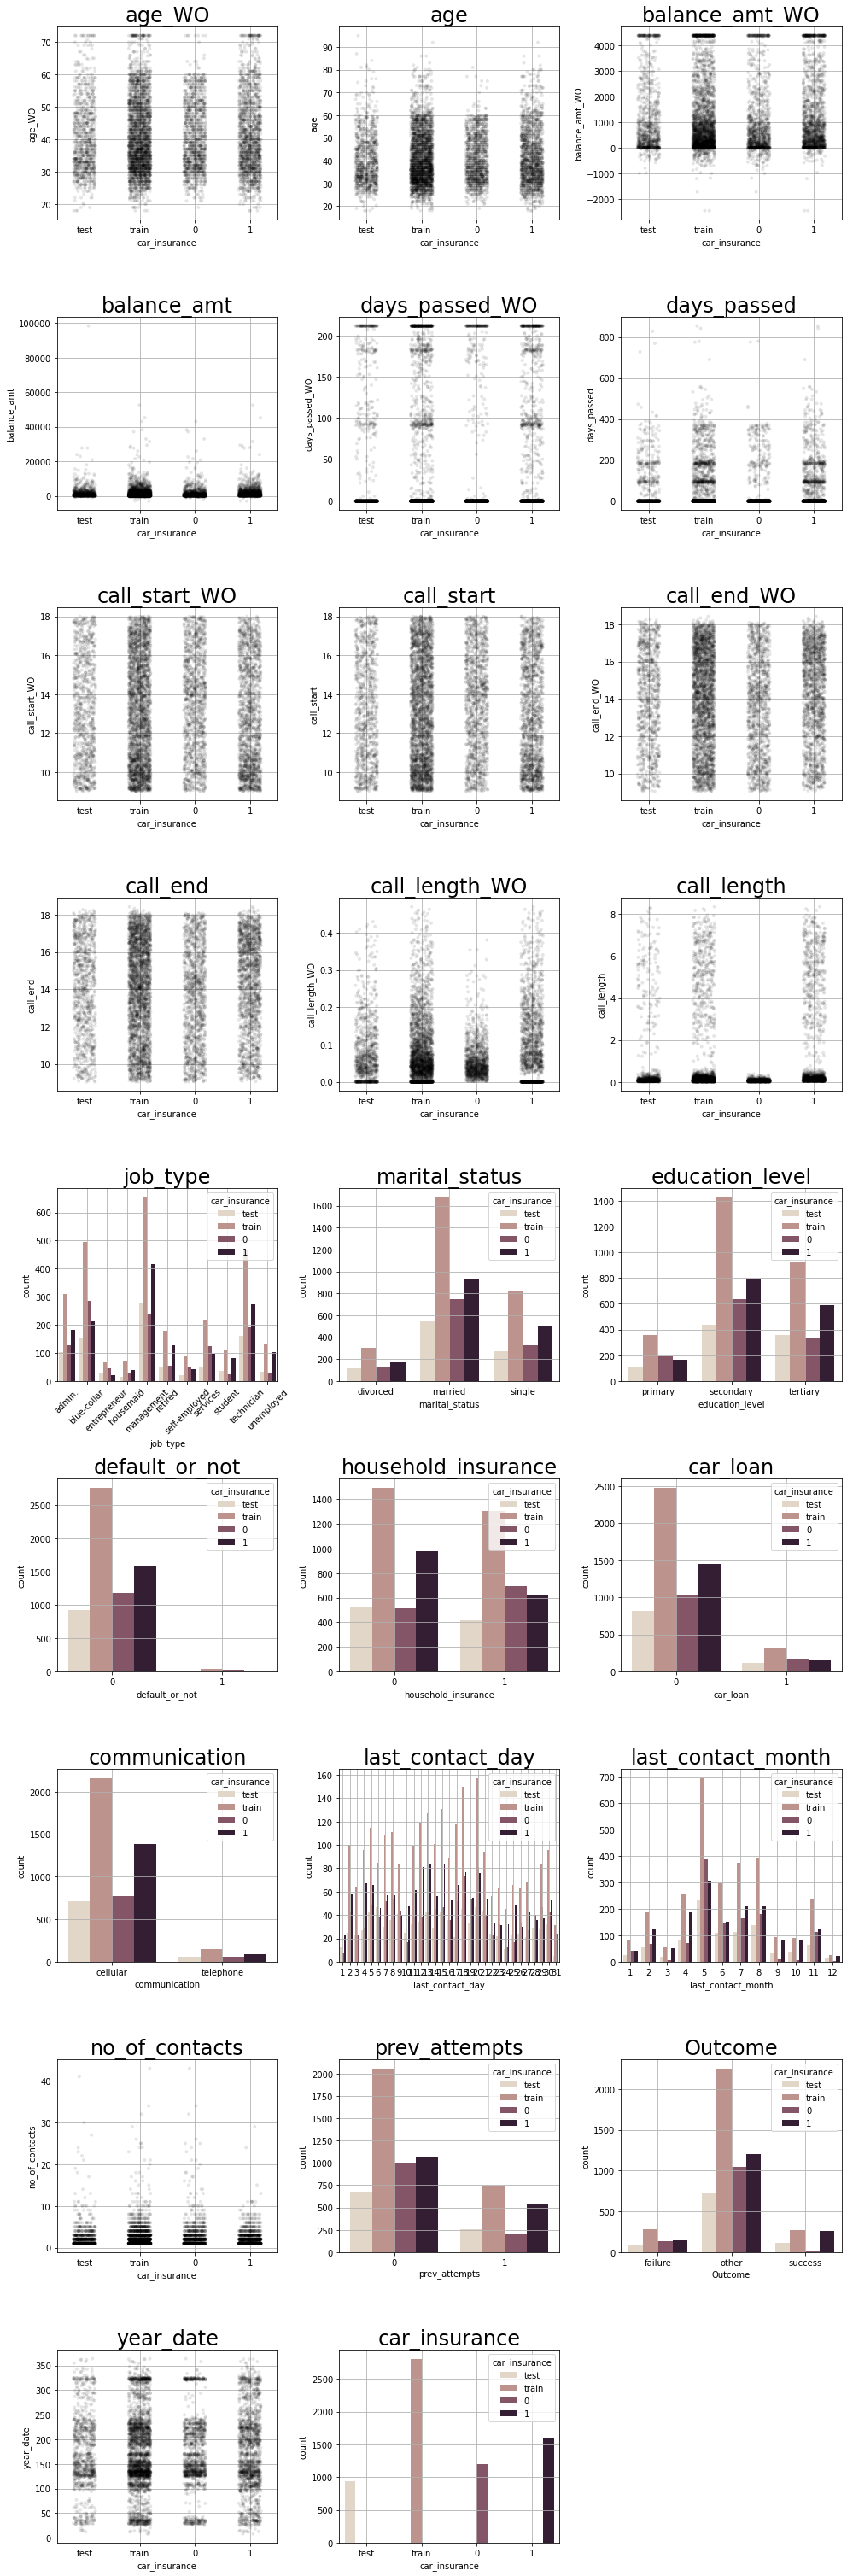

In [14]:
strplot('outlierview', 'both')

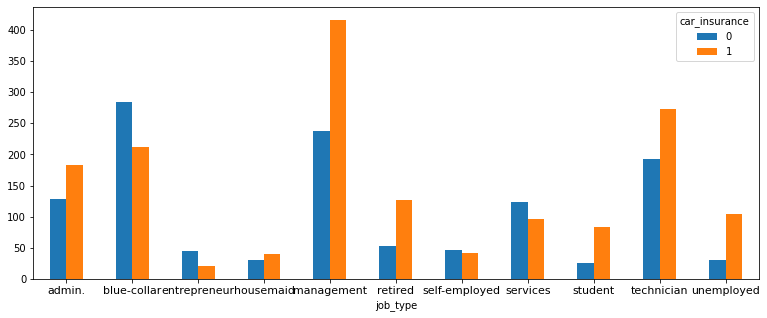

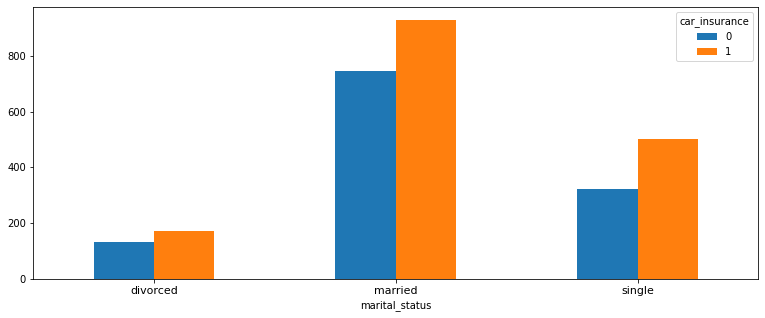

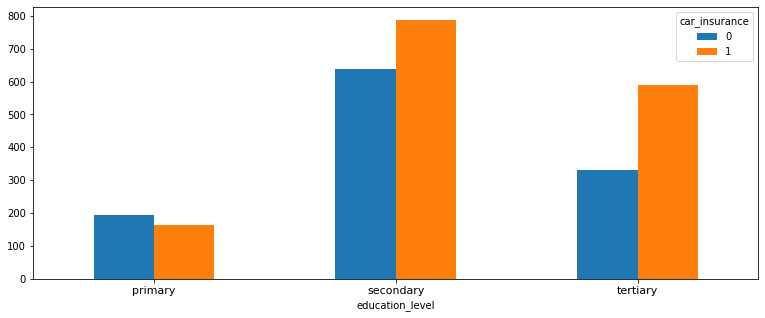

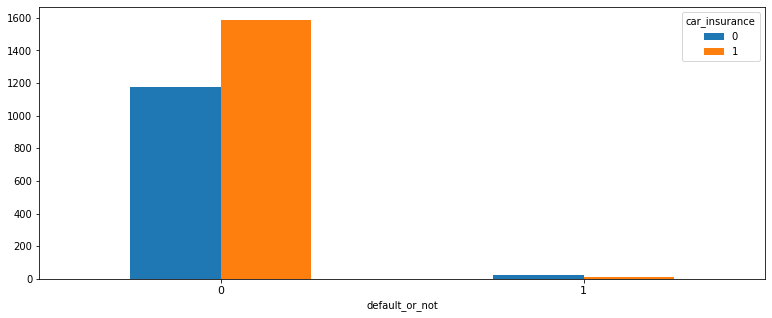

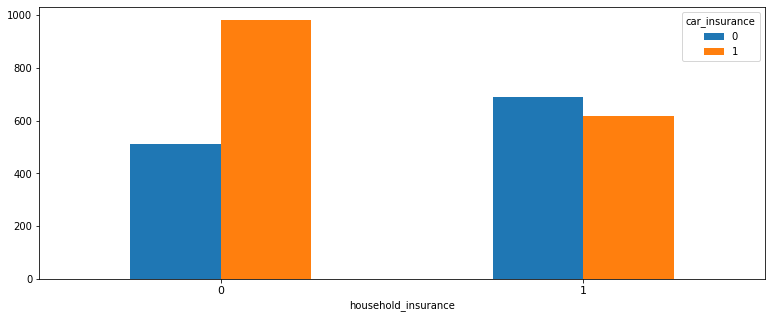

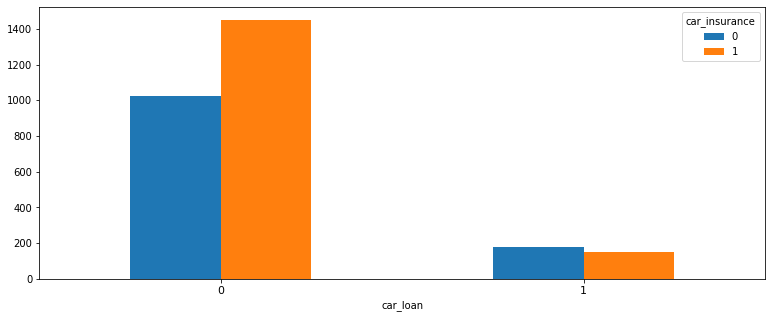

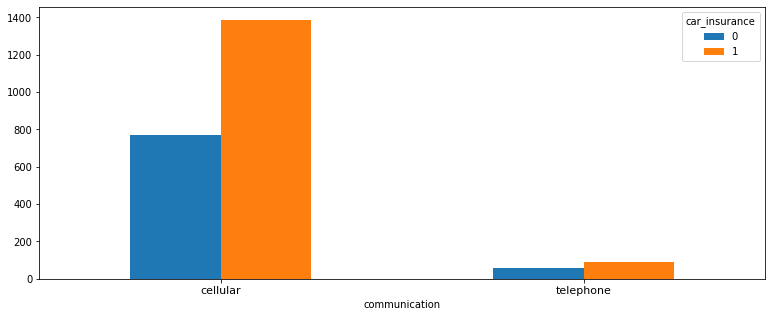

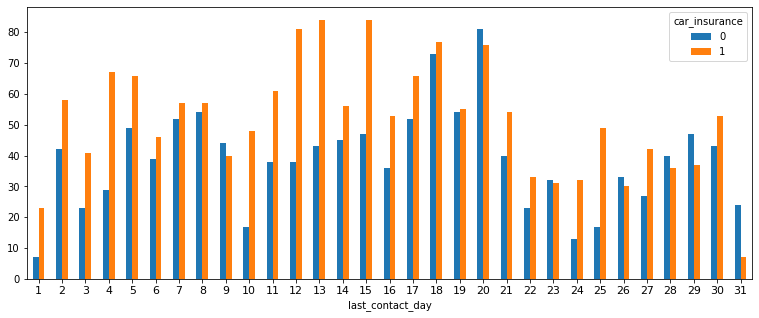

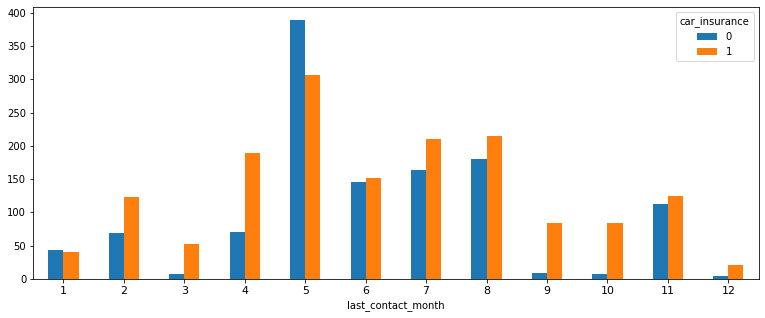

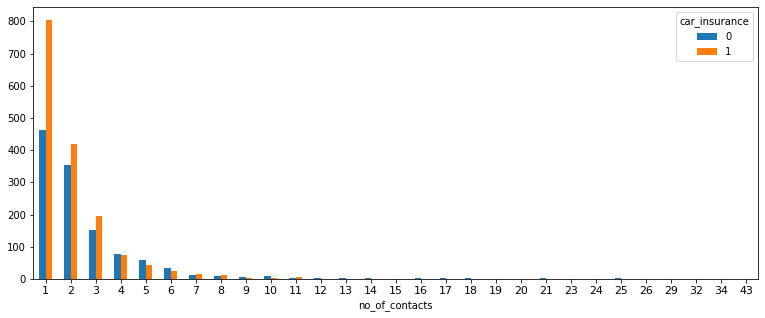

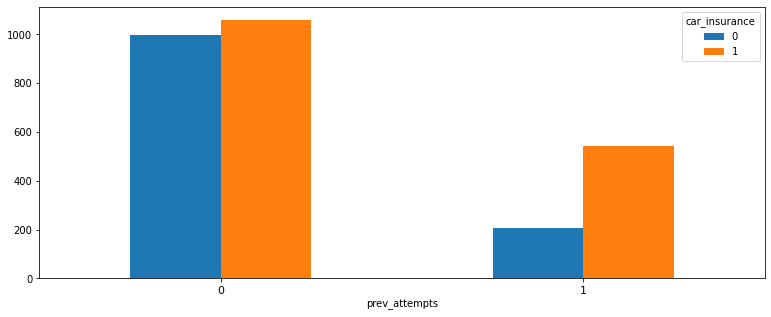

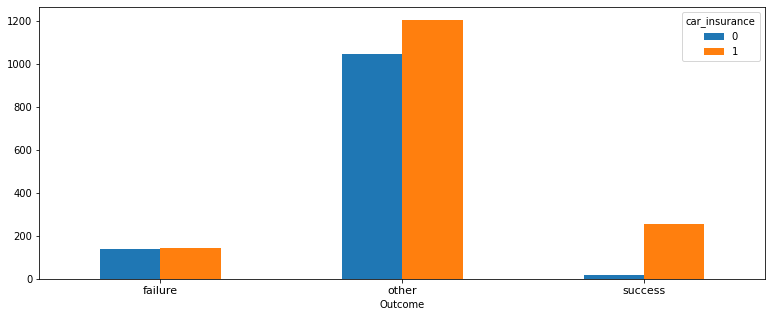

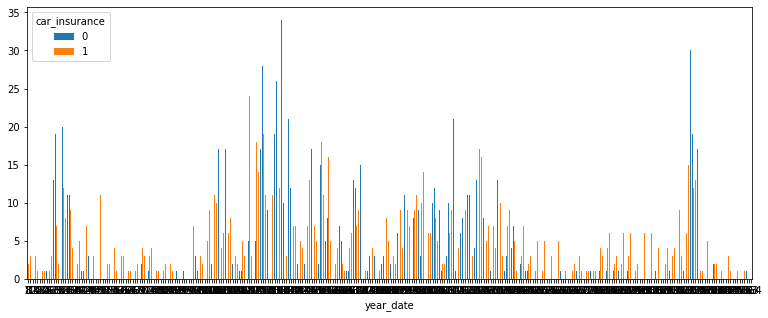

In [15]:
binarycat()

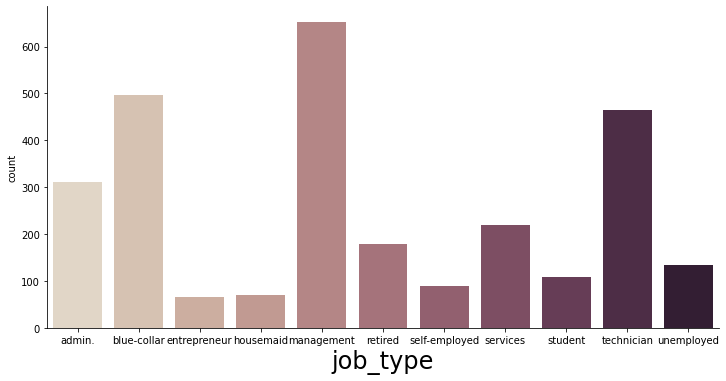

In [16]:
countcat(d, 'job_type')

## Get Dummies

Do get_dummies here, before we're going into the model

In [17]:
d=pd.get_dummies(d,drop_first=True)
f=pd.get_dummies(f,drop_first=True)
dnf=pd.concat((d,f)).fillna(0)
dnf.loc[:,'job_type_blue-collar':]=dnf.loc[:,'job_type_blue-collar':].astype('uint8')
d=dnf.iloc[0:len(d)]
f=dnf.iloc[len(d):].drop('car_insurance',1)
d.car_insurance=d.car_insurance.astype('int64')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Build Machine Learning Model & Evaluate it

Like it said before, there are two styles : using train, do validation, and deploy on test, and another is just using train and test. Both have the advantages and the disadvantages. In the datathon context where the target test is not given, the former may automate the search of the accuracy, but it will not use all the precious data. On the other hand, the latter strategy may cumbersome and painstaking because of its manual handling of tuning (EDA and also the model), but it's really worth to try since it will use all the data and make the accuracy higher. Here I'll use the <u>latter</u>.

Although, I suggest to use the combination of both, or choose it based on your determination hardness.

## Separate Target & Input Variable 

Separate the target and the input variable

In [18]:
target=d.car_insurance
d=d.drop('car_insurance', 1)

## Model Fitting

Fit the model. This model with the those parameter numbers has been manually tuned

In [19]:
model=XGBClassifier(max_depth=6, learning_rate=0.03, subsample=1, gamma=0)
model.fit(d,target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Prediction for Test Dataset (Provided by DPhi)
Predict if the customer would buy the car insurance or not on the test data provided by DPhi here.


In [20]:
g=pd.DataFrame(model.predict(f), columns=['prediction'])
g.to_csv('prediction_result.csv', index=False)

# Saving Prediction File

### Save prediciton results locally via Colab
If you are working on Colab, execute below block of codes. A file named 'prediction_result.csv' will be downloaded.

In [21]:
# Colab Save to download the csv file locally
from google.colab import files
files.download('prediction_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>